# Testing CNN Shape Measurements of Simple Galaxy Models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Tensorflow version: {}".format(tf.version.VERSION))


#keras only after gpu ID and memory usage is set
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds

Tensorflow version: 2.8.0


## CNN Models

In [2]:
def Ribli19(imsize=50, n_target=2 ,n_channels=1, nf=64, reg = 5e-5,
          padding='same', gpu='0'):

    #input
    inp = kl.Input((imsize, imsize,n_channels))
    
    # conv block 1
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 2
    x = kl.Conv2D(2*nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 3
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 4
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 5
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (1, 1), padding=padding,  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    #  end of conv
    
    x = kl.GlobalAveragePooling2D()(x)    
    x = kl.Dense(n_target, name = 'final_dense_n%d_ngpu%d' % (n_target, len(gpu.split(','))))(x)  

    model = km.Model(inputs=inp, outputs=x)  # make model
       
    return model

In [3]:
from autometacal.python.datasets import GalGen

/home/LSC/vitorelli/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Load Data

In [4]:
(datat, datav), ds_info = tfds.load('GalGen/small_stamp_100k',as_supervised=True,split=['train[:14%]', 'train[14%:20%]'],with_info=True)
datat = datat.cache()
datat = datat.shuffle(ds_info.splits['train'].num_examples)
datat = datat.batch(512)
datat = datat.prefetch(tf.data.experimental.AUTOTUNE)

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling gal_gen-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset gal_gen downloaded and prepared to /home/LSC/vitorelli/tensorflow_datasets/gal_gen/small_stamp_100k/2.0.0. Subsequent calls will reuse this data.


In [5]:
datav = datav.cache()
datav = datav.batch(512)
datav = datav.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
datav

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 50), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

NameError: name 'gal_images' is not defined

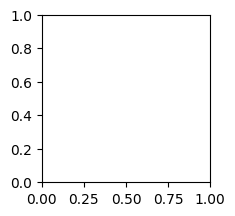

In [14]:
plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

## Generate Model

In [6]:
model = Ribli19(50,n_channels=1)

## Optimise Model

In [7]:
sgd = ko.SGD(lr=0.005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=40,
          validation_data=datav,
          verbose=1)

sgd = ko.SGD(lr=0.0005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=20,
          validation_data=datav,
          verbose=1)

sgd = ko.SGD(lr=0.00005, decay=0., momentum=0.9, nesterov=True)
model.compile(loss='mse',optimizer=sgd, metrics=['mae','mse'])

model.fit(datat,
          epochs=20,
          validation_data=datav,
          verbose=1)

Epoch 1/40


/home/LSC/vitorelli/.local/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


28/28 [==============================] - 24s 394ms/step - loss: 0.2327 - mae: 0.1418 - mse: 0.0395 - val_loss: 0.2550 - val_mae: 0.1994 - val_mse: 0.0619
Epoch 2/40
28/28 [==============================] - 7s 243ms/step - loss: 0.2005 - mae: 0.0679 - mse: 0.0074 - val_loss: 0.2550 - val_mae: 0.1996 - val_mse: 0.0619
Epoch 3/40
28/28 [==============================] - 7s 243ms/step - loss: 0.1967 - mae: 0.0476 - mse: 0.0036 - val_loss: 0.2551 - val_mae: 0.1998 - val_mse: 0.0621
Epoch 4/40
28/28 [==============================] - 7s 243ms/step - loss: 0.1959 - mae: 0.0429 - mse: 0.0029 - val_loss: 0.2545 - val_mae: 0.1988 - val_mse: 0.0616
Epoch 5/40
28/28 [==============================] - 7s 244ms/step - loss: 0.1950 - mae: 0.0357 - mse: 0.0020 - val_loss: 0.2507 - val_mae: 0.1918 - val_mse: 0.0578
Epoch 6/40
28/28 [==============================] - 7s 245ms/step - loss: 0.1951 - mae: 0.0378 - mse: 0.0023 - val_loss: 0.2457 - val_mae: 0.1827 - val_mse: 0.0529
Epoch 7/40
28/28 [========

## Predict on Test Set

In [8]:
test  = datav

#predictions
predictions = model.predict(test)

#labels
test_unb  = test.unbatch()
test_unb_it = test_unb.as_numpy_iterator()
listtest  = [next(test_unb_it) for i in range(len(predictions))]
labels = np.array([listtest[i][1] for i in range(len(predictions))])

## Plot the Results

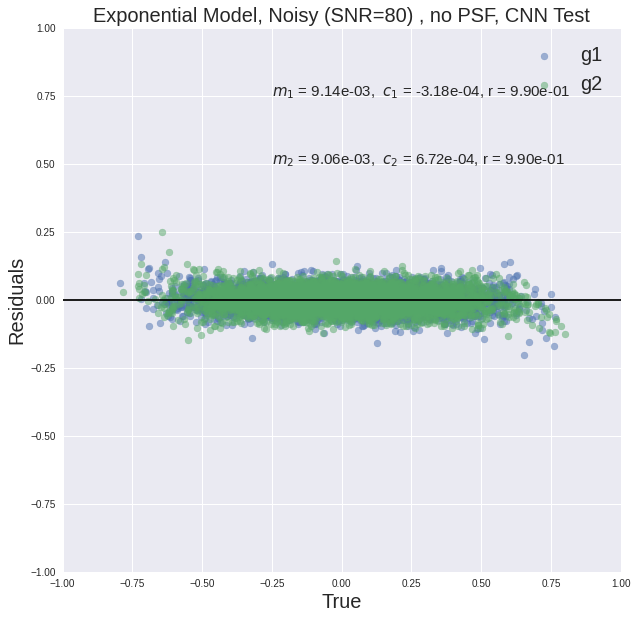

In [9]:
plt.style.use('seaborn')
plt.figure(figsize=(10,10))

#linear fit
poly_g1 = np.polyfit(labels[:,0],predictions[:,0],1)
poly_g2 = np.polyfit(labels[:,1],predictions[:,1],1)

#correlation coefficient
corr_g1 = pearsonr(labels[:,0],predictions[:,0])
corr_g2 = pearsonr(labels[:,1],predictions[:,1])

#plots
plt.scatter(labels[:,0],predictions[:,0]-labels[:,0],alpha=0.5,label='g1')
plt.scatter(labels[:,1],predictions[:,1]-labels[:,1],alpha=0.5,label='g2')

#text
plt.text(-.25,0.75, "$m_1$ = {:.2e},  $c_1$ = {:.2e}, r = {:.2e}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
plt.text(-.25,0.5 , "$m_2$ = {:.2e},  $c_2$ = {:.2e}, r = {:.2e}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

#zero
plt.plot([-1,1],[0,0],'k-')

#settings
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Exponential Model, Noisy (SNR=80) , no PSF, CNN Test",fontsize=20)
plt.xlabel("True",fontsize=20)
plt.ylabel("Residuals",fontsize=20)
plt.legend(fontsize=20)

#save
plt.savefig("first_test.png",bbox_inches="tight")

# Exercise with Enets

In [11]:
from tensorflow.keras.applications import EfficientNetB0